# Scenario 3 subtask 3: Represent Diagnosed Cases

**Background:** 10/02/2020 - 1/25/2021 in Greater Boston area. Predicting cases from wastewater potentially reports closer to the truth than testing.

**TASK:** Calibrate the modified model on 'diagnosed' cases 10/02/202 to 12/18/2020. Plot the forecast through 01/25/2021 alongside the actual 'diagnosed' 

**Specifications:**
2. Data found in supplementary materials

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyciemss.visuals.plots as plots
from pyciemss.PetriNetODE.interfaces import (
    load_and_sample_petri_model,
    load_and_calibrate_and_sample_petri_model,
    load_petri_model,
    setup_petri_model,
    sample
)
from pyciemss.utils.interface_utils import convert_to_output_format
from pyciemss.utils import get_tspan

from mira.sources.askenet.petrinet import model_from_url
from mira.metamodel import Distribution
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel
from mira.modeling import Model
import urllib.request, json
import requests
from pyciemss.PetriNetODE.interfaces import (
    load_and_sample_petri_model,
    load_and_calibrate_and_sample_petri_model
)
import pyciemss.visuals.plots as plots



## Load the Viral load model with diagnosed, undiagnosed, and cumulative cases

In [25]:
S = 2300000
E = 1000
I = 0
(S+E+I)*9.06e-8

0.2084706

In [45]:

from mira.sources.askenet import model_from_json_file

template_model = model_from_json_file('ES3_detection_log10V.json')
template_model.parameters['lambda'].value = 0.208 #9.06e-8
template_model.parameters['lambda'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0.2, "maximum":0.21})
template_model.parameters['gamma'].value = 0.125
template_model.parameters['beta'].value = 44852600
template_model.parameters['k'].value = 0.5
template_model.parameters['k'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0.25, "maximum":0.5})

template_model

TemplateModel(templates=[ControlledConversion(rate_law=I*S*lambda/(E + I + S), name='t1', type='ControlledConversion', controller=Concept(name='I', display_name='I', description=None, identifiers={'ido': '0000511'}, context={}, units=Unit(expression=person)), subject=Concept(name='S', display_name='S', description=None, identifiers={'ido': '0000514'}, context={}, units=Unit(expression=person)), outcome=Concept(name='E', display_name='E', description=None, identifiers={'apollosv': '0000154'}, context={}, units=Unit(expression=person)), provenance=[]), NaturalConversion(rate_law=E*k, name='t2', type='NaturalConversion', subject=Concept(name='E', display_name='E', description=None, identifiers={'apollosv': '0000154'}, context={}, units=Unit(expression=person)), outcome=Concept(name='I', display_name='I', description=None, identifiers={'ido': '0000511'}, context={}, units=Unit(expression=person)), provenance=[]), NaturalDegradation(rate_law=I*delta, name='t3', type='NaturalDegradation', su

## Uncalibrated samples

In [46]:
num_samples = 10
timepoints = [i/10.0 for i in range(1150)]


prior_samples = load_and_sample_petri_model(template_model, num_samples, timepoints, method='dopri5',  visual_options={"title": "3_base", "subset":["V_sol"]}, time_unit="days")
prior_samples['data'].set_index(['timepoint_id', 'sample_id']).groupby('timepoint_id').mean()

,lambda_param,k_param,alpha_param,delta_param,beta_param,gamma_param,C_sol,D_sol,E_sol,I_sol,S_sol,U_sol,V_sol,logV_obs,timepoint_days
timepoint_id,,,,,,,,,,,,,,,
0,0.203813,0.385209,360.620375,0.125,44852600.0,0.125,3.920993e-19,1.557040e-19,1000.000000,3.852088e-08,2.300000e+06,2.363953e-19,3.424865e+13,13.534644,0.0
1,0.203813,0.385209,360.620375,0.125,44852600.0,0.125,3.853755e-01,1.529756e-01,962.614673,3.753422e+01,2.299999e+06,2.323998e-01,3.427563e+13,13.534986,0.1
2,0.203813,0.385209,360.620375,0.125,44852600.0,0.125,1.515382e+00,6.013093e-01,927.414081,7.317096e+01,2.299999e+06,9.140729e-01,3.435477e+13,13.535987,0.2
3,0.203813,0.385209,360.620375,0.125,44852600.0,0.125,3.352531e+00,1.329810e+00,894.274921,1.070191e+02,2.299997e+06,2.022722e+00,3.448341e+13,13.537608,0.3
4,0.203813,0.385209,360.620375,0.125,44852600.0,0.125,5.861480e+00,2.324171e+00,863.081445,1.391812e+02,2.299994e+06,3.537310e+00,3.465907e+13,13.539809,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,0.203813,0.385209,360.620375,0.125,44852600.0,0.125,8.407523e+05,3.350982e+05,80407.007422,1.974721e+05,1.459248e+06,5.056542e+05,6.210392e+16,16.724271,114.5
1146,0.203813,0.385209,360.620375,0.125,44852600.0,0.125,8.440758e+05,3.364157e+05,80620.038672,1.981102e+05,1.455925e+06,5.076601e+05,6.237555e+16,16.726173,114.6
1147,0.203813,0.385209,360.620375,0.125,44852600.0,0.125,8.474071e+05,3.377360e+05,80832.600000,1.987483e+05,1.452594e+06,5.096707e+05,6.264804e+16,16.728073,114.7


## Plot the viral load data

,V
time,
0,3.424864e+13
1,7.482611e+13
2,1.107730e+14
3,1.455132e+14
4,1.789461e+14
...,...
221,1.256720e+17
222,1.257698e+17
223,1.258096e+17


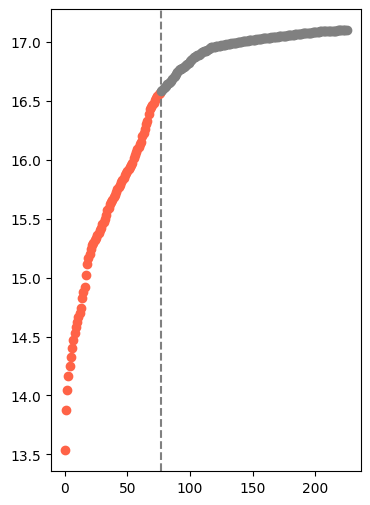

In [18]:
# Load Data
## This uses the cumsum() of the raw data
data_train = pd.read_csv('./data/processed_dataset_train.csv', index_col="time")
data_test  = pd.read_csv('./data/processed_dataset_test.csv', index_col="time")
data_whole = pd.read_csv('./data/processed_dataset.csv', index_col="time")
display(data_whole)

# Plot
plt.figure(figsize=(4,6))
plt.scatter(data_train.index, np.log10(data_train.V), color='tomato')
plt.scatter(data_test.index, np.log10(data_test.V), color='grey')
plt.axvline(77, linestyle='dashed', color='grey')

## Plot measured viral load data against uncalibrated model viral load

In [47]:
schema = plots.trajectories(pd.DataFrame(prior_samples["data"]), subset="V_sol",
                            markers={"Training": 77},
                            points=data_whole.reset_index(drop=True).rename(columns={"V":"V_data"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

## Plot the diagnosed cases data

In [30]:
cases = pd.read_csv('data/datasetCumulCases.csv').dropna(how='any')
incident_cases = cases[['Time', 'cumulativecases']].rename(columns={'cumulativecases': 'reported incident cases', 'Time': 'Timestep'}).set_index('Timestep').diff().dropna()



In [14]:
measured_diagnosed_cases = pd.read_csv('data/cumulative_cases.csv')
measured_diagnosed_cases

,Timestep,D
0,0,370.0
1,1,668.0
2,2,978.0
3,3,1133.0
4,4,1332.0
...,...,...
108,111,136330.0
109,112,138392.0
110,113,140192.0
111,114,141854.0


## Plot measured diagnosed case data against uncalibrated model diagnosed cases

In [48]:
schema = plots.trajectories(pd.DataFrame(prior_samples["data"]), subset="D_sol",
                            #markers={"Training": 77},
                            points=measured_diagnosed_cases.drop('Timestep',axis=1))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

In [54]:
data_train['D'] = measured_diagnosed_cases.drop('Timestep',axis=1)
data_train.reset_index().rename(columns={'time':'Timestep'}).to_csv('data/viral_load_and_diagnosed_cases.train.csv', index=False)

## Calibrate against diagnosed case data

In [59]:
calibrated_samples = load_and_calibrate_and_sample_petri_model(
            template_model,
            'data/viral_load_and_diagnosed_cases.train.csv',
            100,
            timepoints=timepoints,
            verbose=True,
            num_iterations=1000,
            visual_options={"title": "3_base", "subset":["V_sol"]}, time_unit="days")

/Users/zuck016/Projects/Proposals/ASKEM/build/pyciemss/src/pyciemss/PetriNetODE/interfaces.py:864: UserWarning: Observation ObservationEvent(time=1.0000048875808716, observation={'V': tensor(7.4826e+13), 'D': tensor(668.)}) is not in the range [0, 34248648032256.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/zuck016/Projects/Proposals/ASKEM/build/pyciemss/src/pyciemss/PetriNetODE/interfaces.py:864: UserWarning: Observation ObservationEvent(time=2.0000076293945312, observation={'V': tensor(1.1077e+14), 'D': tensor(978.)}) is not in the range [0, 34248648032256.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/zuck016/Projects/Proposals/ASKEM/build/pyciemss/src/pyciemss/PetriNetODE/interfaces.py:864: UserWarning: Observation ObservationEvent(time=3.000001907348633, observation={'V': tensor(1.4551e+14

iteration 0: loss = 26802.839638233185
iteration 25: loss = 11331.887666463852
iteration 50: loss = 8846.11881351471
iteration 75: loss = 7803.896865367889
iteration 100: loss = 7022.951460123062
iteration 125: loss = 6685.4540367126465
iteration 150: loss = 6538.586189746857
iteration 175: loss = 6232.020425319672
iteration 200: loss = 6243.9412178993225
iteration 225: loss = 6157.514747619629
iteration 250: loss = 6054.7181169986725
iteration 275: loss = 5975.071290016174
iteration 300: loss = 5970.9834225177765
iteration 325: loss = 5865.00360250473
iteration 350: loss = 5823.579279899597
iteration 375: loss = 5826.580198287964
iteration 400: loss = 5789.240880012512
iteration 425: loss = 5751.058431386948
iteration 450: loss = 5710.214222192764
iteration 475: loss = 5726.305196285248
iteration 500: loss = 5687.944588184357
iteration 525: loss = 5656.623008728027
iteration 550: loss = 5660.947656393051
iteration 575: loss = 5630.509786128998
iteration 600: loss = 5647.111279964447
i

In [65]:
schema = plots.trajectories(pd.DataFrame(calibrated_samples["data"]), subset="D_sol",
                            markers={"Training": 77},
                            points=measured_diagnosed_cases.drop('Timestep',axis=1).rename(columns={'D': 'measured diagnosed cases'}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

In [66]:
schema = plots.trajectories(pd.DataFrame(calibrated_samples["data"]), subset="V_sol",
                            markers={"Training": 77},
                            points=data_whole.reset_index(drop=True).rename(columns={"V":"measured viral load"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

In [73]:
sorted(set(calibrated_samples['data']['k_param'].values))

[0.49245786666870117,
 0.4926827549934387,
 0.49269723892211914,
 0.4929702877998352,
 0.49297165870666504,
 0.4929906725883484,
 0.4930049180984497,
 0.4930081367492676,
 0.4930495619773865,
 0.49309617280960083,
 0.4931265711784363,
 0.49313491582870483,
 0.49317240715026855,
 0.4931854009628296,
 0.49319279193878174,
 0.4932337999343872,
 0.4932381510734558,
 0.4932810664176941,
 0.4932909309864044,
 0.49330711364746094,
 0.49331676959991455,
 0.4933374524116516,
 0.49334806203842163,
 0.4933919906616211,
 0.4934238791465759,
 0.49345505237579346,
 0.49347516894340515,
 0.4934781491756439,
 0.493508905172348,
 0.4935130476951599,
 0.493517130613327,
 0.4935237467288971,
 0.49355533719062805,
 0.49358516931533813,
 0.493655264377594,
 0.49366676807403564,
 0.49368786811828613,
 0.49369269609451294,
 0.49371498823165894,
 0.49374306201934814,
 0.4937443137168884,
 0.4937605857849121,
 0.4937676787376404,
 0.49377021193504333,
 0.4937805235385895,
 0.4937930703163147,
 0.49380016326904